In [2]:
import random as rng

import imageio
import matplotlib.pyplot as plt
import numpy as np

from skimage import exposure
from skimage import filters
import cv2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Grab an ND2 File and take the first image off of it.
import nd2reader
from pims import ND2_Reader as nd2_sdk

INPUT_FILE = "../data/agarose_pads/SR15_1mM_IPTG_Agarose_TS_1h_1.nd2"

def get_raw():
    with nd2reader.ND2Reader(INPUT_FILE) as input_frames:
        return input_frames[0]

In [82]:
def display_frame(input_frame):
    plt.imshow(
        input_frame,
        cmap='gray',
        interpolation='nearest',
    )

def downsample_image(input_frame: np.ndarray) -> np.ndarray:
    '''
    Downsamples a 16bit input image to an 8bit image. Will result in loss
    of signal fidelity due to loss of precision.

    Args:
        input_frame: Input numpy array

    Returns:
        Downsampled ndarray
    '''
    return (input_frame / 256).astype('uint8')

def downsample(input_frame):
    return (255 * input_frame / np.max(input_frame)).astype(np.uint8)

def threshold(input_frame, low=2, high=98):
    low_threshold = np.percentile(input_frame, low)
    high_threshold = np.percentile(input_frame, high)
    ret, thresh = cv2.threshold(input_frame, low_threshold, high_threshold, 0)
    return thresh

def invert_image(input_frame):
    return np.invert(input_frame)

def remove_background(input_frame, adjustment: float = 1.0):
    background_level = np.mean(input_frame) * adjustment
    return input_frame - background_level

def kernel(input_frame):
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(input_frame, -1, kernel)

def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened


def find_countours(input_frame):
    inner_contours, hierarchy = cv2.findContours(
        input_frame,
        cv2.RETR_TREE,
        cv2.CHAIN_APPROX_NONE,
    )
    return inner_contours

def draw_convex_hull(edges, contours):
        # Find the convex hull object for each contour
        hull_list = []
        for i in range(len(contours)):
            hull = cv2.convexHull(contours[i])
            hull_list.append(hull)
        # Draw contours + hull results
        drawing = np.zeros((edges.shape[0], edges.shape[1], 3), dtype=np.uint8)
        for i in range(len(contours)):
            color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
            cv2.drawContours(drawing, contours, i, color)
            cv2.drawContours(drawing, hull_list, i, color)
        return drawing

def gaussian_blur(input_frame, kernel: int=3):
    return cv2.GaussianBlur(input_frame, (kernel, kernel), 0)

def laplacian_operator(input_frame):
    return cv2.Laplacian(input_frame, cv2.CV_64F, ksize=3)

def otsu_thresholding(input_frame):
    blur = cv2.GaussianBlur(input_frame,(3,3),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3

def auto_canny(image, sigma=0.01):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	return cv2.Canny(image, lower, upper)

def pyramid_mean_shift(input_frame, lower=21, upper=51):
    return cv2.pyrMeanShiftFiltering(input_frame, lower, upper)



8192.0


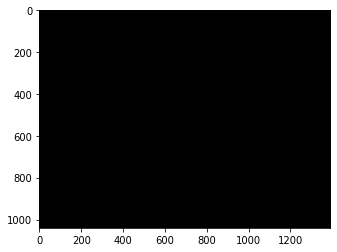

In [34]:
def watershed_approach():
    gray = get_raw()
    # gray = unsharp_mask(gray)
    # ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    thresh = threshold(gray)
    thresh = invert_image(thresh)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(downsample_image(opening) ,cv2.DIST_C,0)
    print(dist_transform.max())
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(downsample_image(sure_bg),sure_fg)
    display_frame(unknown)

watershed_approach()

In [124]:
from IPython.display import display
from ipywidgets import IntSlider
@interact(low_threshold = IntSlider(min=0, max=100, step=1, value=2), high_threshold=IntSlider(min=0, max=200, step=1, value=98))
def attempt_2(low_threshold, high_threshold):
    out = get_raw()
    # out = laplacian_operator(out)
    mask = np.zeros_like(out)
    out = remove_background(invert_image(threshold(out, low_threshold, high_threshold)), 1)
    out = downsample_image(out)
    # out = cv2.Canny(out, low_threshold, high_threshold)
    contours, hierarchy = cv2.findContours(out, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contour_areas = map(cv2.contourArea, contours)
    hist, bin_edges = np.histogram(contour_areas, bins=10)
    out = cv2.drawContours(mask, contours, -1, (255, 255, 255), -1)
    display_frame(out)
## So, what we need to do is:
#   1) Filter detrius from the resultant contours by summating all the median areas of the
#   other contours and creating a low-pass filter from the histogram bins.
#
#   2) Once you are good to go on that, we need to figure out how you can take a contour
#   area and use it as a way to calculate mean fluroesence in the green/red channels.
#
#   3) We then need to be able to take it and apply it to the videos.
#
#   4) We then need to generate some of the charts that Sam required.
#
#   5) We then need to refine our approach in terms of segmentation either via eroding
#   or some other mechanism.

interactive(children=(IntSlider(value=2, description='low_threshold'), IntSlider(value=98, description='high_t…

In [ ]:
from ipywidgets import IntSlider
@interact(low_threshold = IntSlider(min=0, max=100, step=1, value=2), high_threshold=IntSlider(min=0, max=100, step=1, value=98))
def percentile_thresholding(low_threshold, high_threshold):
    input_image = get_raw()
    out_image = threshold(input_image, low_threshold, high_threshold)
    display_frame(out_image)

In [ ]:
@interact(canny_low_one=140, canny_high_one=210)
def canny_testing(canny_low_one, canny_high_one):
    print(1)
    _input_image = get_raw()
    _out_image = threshold(_input_image, 2, 98)
    edge = cv2.Canny(_out_image, canny_low_one, canny_high_one)
    # Chain Approx None is very important due to the amorphous nature of the
    # underlying cells.
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        hull = cv2.convexHull(c)
        cv2.drawContours(_out_image, [hull], 0, (0, 255, 0), 2)
    display_frame(_out_image)


In [ ]:
@interact(canny_low=100, canny_high=100, do_threshold=True)
def pipeline_experiment(canny_low, canny_high, do_threshold):
    raw_frame = get_raw()
    mask = np.zeros(raw_frame.shape, np.uint8)
    carry_frame =  downsample_image(raw_frame)
    if do_threshold:
        carry_frame = threshold(carry_frame)
    display_frame(unsharp_mask(carry_frame))
    edges = cv2.Canny(carry_frame, canny_low, canny_high)
    display_frame(edges)
    contours = find_countours(edges)
    # display_frame(draw_convex_hull(edges, contours))
    # draw_convex_hull(edges, contours)
    # display_frame(mask)
    cv2.imwrite('test.jpg', mask)
    raw_frame[mask == 255] = raw_frame[mask == 255]

In [ ]:
@interact(kernel_median= IntSlider(min=0, max=100, step=1, value=2, canny_high=100, do_threshold=True))
def kernel_test(kernel_median):
    input_frame = get_raw()
    kernel = np.array([[-1,-1,-1], [-1,kernel_median,-1], [-1,-1,-1]])
    display_frame(cv2.filter2D(input_frame, -1, kernel))

In [ ]:
@interact(kernel_median= IntSlider(min=0, max=100, step=1, value=2, canny_high=100, do_threshold=True))
def billateral_filtering(kernel_median):
    input_frame = get_raw()
    kernel = np.array([[-1,-1,-1], [-1,kernel_median,-1], [-1,-1,-1]])
    display_frame(cv2.filter2D(input_frame, -1, kernel))

In [ ]:
input_image = imageio.imread(example_file)
val = filters.sobel(input_image)

hist, bins_center = exposure.histogram(input_image)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(
    input_image,
    cmap='gray',
    interpolation='nearest',
)
thresholded_array = input_image > val
thresholded_array = np.logical_not(thresholded_array)
plt.axis('off')
plt.subplot(132)
plt.imshow(
    thresholded_array,
    cmap='gray',
    interpolation='nearest',
)
np.clip(input_image, 1689, 1690)
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.show()
